In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

## Plotting function

In [ ]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

## Defining input

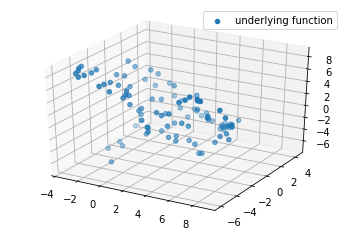

In [ ]:
bias_true = torch.FloatTensor([1,-1])
x = rand_tensor = torch.rand((100, 3))
weights_1 = torch.FloatTensor([[1, 1,0],[1,0,1]]).T
weights_2 = torch.FloatTensor([[0,0,1],[0,1,0]]).T

y_true = torch.matmul(torch.square(x) , weights_1) +  torch.matmul(x , weights_2) + bias_true
X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)

plot_3d(X_embedded, y_embedded)


##Loss function and Linear layer

In [ ]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.square(x)@ self.weights + x @ self.weights + self.bias
    return output

  # dy/dx = 2*x*weights_true + weights_true
  # dy/dw = x2 + x
  # dy/db = 1
  def backward(self, gradient):
    self.weights_gradient = (torch.square(self.x) + self.x).T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T

    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

## Relu layer

In [ ]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

## Defining model

In [ ]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, 6)
    self.relu = Relu()
    self.linear2 = Linear(6, 4)
    self.relu2 = Relu()
    self.linear3 = Linear(4, 2)

  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):

    linear3_gradient = self.linear3.backward(output_gradient)
    relu_gradient = self.relu2.backward(linear3_gradient)

    linear2_gradient = self.linear2.backward(relu_gradient)
    relu2_gradient = self.relu.backward(linear2_gradient)

    linear1_gradient = self.linear1.backward(relu2_gradient)
    return linear3_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(3, 1)
y_pred = model(x)
print(y_pred.shape)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)

# y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred_tensor)
# X_embedded = TSNE(n_components=2).fit_transform(x_tensor)
# y_embedded = TSNE(n_components=1).fit_transform(y_true_tensor)
# plot_3d(X_embedded, y_embedded,y_pred_embedded)

## Training function

Epoch 0, loss 0.24869073927402496
Epoch 1, loss 0.248606875538826
Epoch 2, loss 0.24852804839611053
Epoch 3, loss 0.24845384061336517
Epoch 4, loss 0.24838405847549438
Epoch 5, loss 0.24831825494766235
Epoch 6, loss 0.24825626611709595
Epoch 7, loss 0.2481977790594101
Epoch 8, loss 0.2481425404548645
Epoch 9, loss 0.24809041619300842
Epoch 10, loss 0.2480410933494568
Epoch 11, loss 0.2479945421218872
Epoch 12, loss 0.24795041978359222
Epoch 13, loss 0.24790865182876587
Epoch 14, loss 0.247869074344635
Epoch 15, loss 0.2478315234184265
Epoch 16, loss 0.2477959394454956
Epoch 17, loss 0.24776211380958557
Epoch 18, loss 0.24773003160953522
Epoch 19, loss 0.24769946932792664
Epoch 20, loss 0.24767042696475983
Epoch 21, loss 0.24764274060726166
Epoch 22, loss 0.24761642515659332
Epoch 23, loss 0.2475913017988205
Epoch 24, loss 0.24756738543510437
Epoch 25, loss 0.24754451215267181
Epoch 26, loss 0.24752269685268402
Epoch 27, loss 0.24750183522701263
Epoch 28, loss 0.24748188257217407
Epoch 

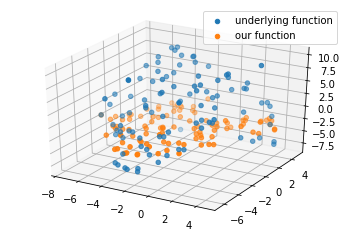

In [ ]:
num_epochs=70
lr=0.02
for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y_true)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)
y_pred= model(x).detach()
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)
X_embedded = TSNE(n_components=2).fit_transform(x.detach())
y_embedded = TSNE(n_components=1).fit_transform(y_true)
plot_3d(X_embedded, y_embedded,y_pred_embedded)